## Final Project Report - Group 25 

##### **Group Members:** 
##### Lauryn Li 
##### Assel Jolaman 
##### Poj Taweepolcharoen 
##### Mustafa Tiritoglu

### Introduction 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In an attempt to learn more about how people play games, a research group at UBC has been hosting a Minecraft server and having research participants play on it while recording information about both their demographic, as well as their activity on the server. In regards to this study, one major question the researchers have encountered is how to best specify their recruitment efforts such that they can target the potential subjects who will contribute the most data to their experiment. This is because as with any scientific experiment the resources available to the researchers are limited, and as such they can only recruit a finite amount of subjects for their study. There is thus an incentive for the researchers to seek to identify the traits that are most strongly correlated to the highest time spent playing on the server, based on a statistical analysis of the data collected on the subject’s demographic information. They can then use this information to be more specific in their future recruitment efforts, and hopefully improve the size of their collected data by targeting a certain type of research subject.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We will be using the players.csv dataset to help us predict if there is a relationship between the player’s age and playing time. This data set includes a list of all the minecraft players, including both quantitative or qualitative data about each player that makes them unique. It includes 196 observations and 7 variables that include experience, subscribe, hashedemail, played_hours, name and Age. Looking at the data set from a glance, we noticed some issues that made it hard to understand, which could potentially lead to uncertainty in our results and predictions. The first issue is that the “Experience” column seems ambiguous as we don’t know how this was assigned to each player. For example, there are some players with 50+ hours of playing time but are only assigned as “amateur”, whereas other players with less than 50 hours of playing time are assigned as “pro”. Therefore it is unclear whether or not the experience of the player contributes to the amount of playing time and if this variable would be a good predictor. Another issue is that the “age” column is missing some values, which could lead to an incomplete analysis and potentially skew the data.

#### players.csv Dataset Variables 

| Name of Variable |      Type    |               Description            |
| ---------------- | ------------ | ------------------------------------ | 
|    experience    |  Categorical | Experience level of the player  |
|    subscribe     |  Categorical |             If the player is subscribed to a game-related newsletter                | 
|    hashedEmail   |  Categorical | Player ID                            |
|    played_hours  | Quantitative |Hours played in Minecraft             |
|       name       |  Categorical | Name of Player                       |
|      gender      |  Categorical | Gender identity of the player |
|       Age        | Quantitative | Age of Player 



### Methods & Results 

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
sessions_url <- "https://raw.github.students.cs.ubc.ca/assel17/data/main/sessions.csv?token=GHSAT0AAAAAAAAAIL22VPRBEUWNDNO3ZR5OZ7ZSPYA"
sessions <- read_csv(sessions_url)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
players_url <- "https://raw.github.students.cs.ubc.ca/assel17/data/main/players.csv?token=GHSAT0AAAAAAAAAIL222LIKC73UMFIKZLZOZ7ZSPIQ"

players <- read_csv(players_url)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# mean values for each quantitative variables (players_hours, Age)

mean_played_hours <- mean(players$played_hours, na.rm = TRUE)
mean_age <- mean(players$Age, na.rm = TRUE)

mean_table <- data.frame(
  metric = c("mean played hours", "mean age"),
  mean_value = c(mean_played_hours, mean_age))

mean_table

metric,mean_value
<chr>,<dbl>
mean played hours,5.845918
mean age,20.520619


In [5]:
players <- players |>
    select(Age, played_hours) |> 
    filter(!is.na(Age))

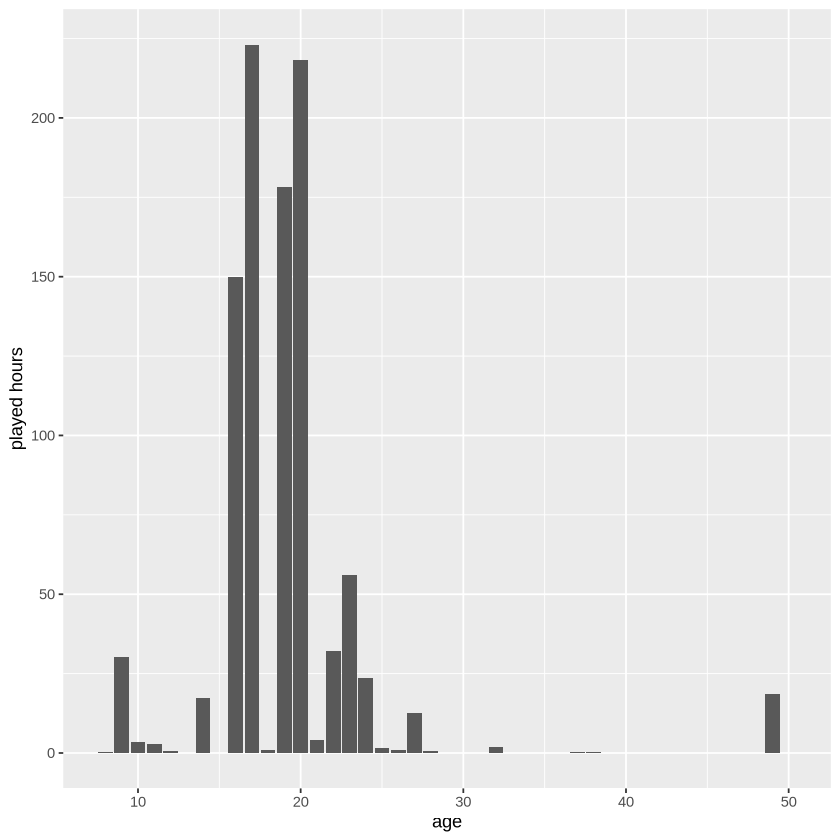

In [6]:
plot_age <- players |> 
    ggplot(aes(x = Age, y = played_hours)) +
    geom_bar(stat = "identity", position = "dodge") + 
    labs(x = "age", y = "played hours")

plot_age

In [7]:
players_split <- initial_split(players, prop = 0.75)
players_training <- training(players_split)
players_testing <- testing(players_split)

In [8]:
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

players_recipe <- recipe(played_hours ~ Age, data = players_training) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

players_vfold <- vfold_cv(players_training, v = 5)

players_wkflw <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec)

In [9]:
gridvals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

players_results <- players_wkflw |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

players_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,27.55388,5,8.706037,Preprocessor1_Model01
2,rmse,standard,26.16472,5,8.516925,Preprocessor1_Model02
3,rmse,standard,29.07769,5,7.259618,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,rmse,standard,25.38252,5,8.378330,Preprocessor1_Model18
19,rmse,standard,25.21902,5,8.454888,Preprocessor1_Model19
20,rmse,standard,24.97030,5,8.555356,Preprocessor1_Model20


In [10]:
players_min <- players_results |>
  filter(mean == min(mean))

players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,rmse,standard,24.63543,5,9.080568,Preprocessor1_Model09


In [11]:
kmin <- players_min |> pull(neighbors)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  fit(data = players_training)

players_summary <- players_fit |>
  predict(players_testing) |>
  bind_cols(players_testing) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,26.89634


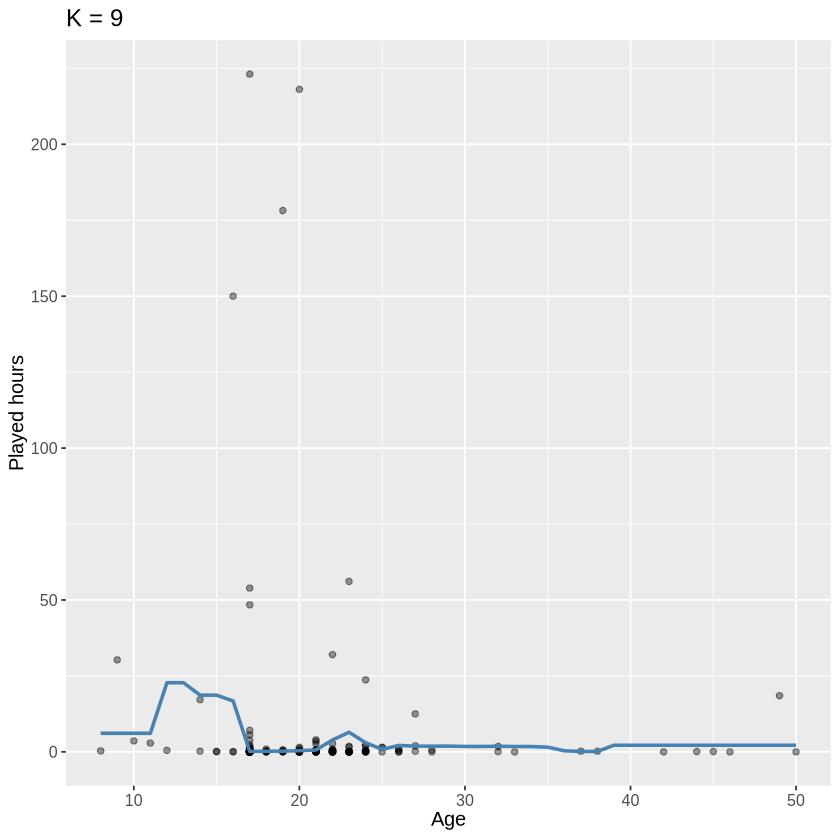

In [12]:
age_prediction_grid <- tibble(
    Age = seq(
        from = players |> select(Age) |> min(),
        to = players |> select(Age) |> max(),
        by = 1
    )
)

players_preds <- players_fit |>
  predict(age_prediction_grid) |>
  bind_cols(age_prediction_grid)

plot_final <- ggplot(players, aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.4) +
  geom_line(data = players_preds,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Age") +
  ylab("Played hours") +
  ggtitle(paste0("K = ", kmin)) +
  theme(text = element_text(size = 12))

plot_final

### Discussion